# Projekt: Wykrywanie spamu wiadomości e-mail przy pomocy naiwnego klasyfikatora Bayesa i SVM

Autor: Konrad Woźniak

## Opis projektu

### Cel projektu

Celem projektu jest zastosowanie algorytmów wspomagania decyzji do procesu wspomagania filtracji wiadomości e-mail typu spam. Projekt opiera się na wykorzystaniu klasycznego zastosowania algorytmu Bayesowskiego do filtrowania spamu oraz algorytmu SVM (Support Vector Machines). Jest to projekt wykonany w środowisku programistycznym Python, wykorzystując przy tym Jupyter Nootebook. 

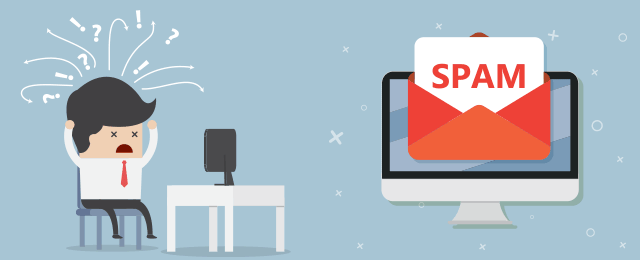

In [12]:
from IPython.display import Image
Image(filename="img/spam1.png")

### Zbiór danych

Zbiór danych wykorzystany w projekcie został pobrany z serwisu kaggle.com i jest on plikiem typu csv. Plik posiada prawie 5700 różnych wiadomości.

Link do zbioru danych kaggle:

https://www.kaggle.com/datasets/rockinjas123/spam-ham-emails

### Spam vs ham

Termin spamu jest dość jasny - to niechciana i zwykle masowo wysyłana poczta elektroniczna lub wiadomość tekstowa, która zazwyczaj ma charakter reklamowy lub propagandowy. Często zawiera ona oferty niechcianych produktów lub usług, a czasem również zawiera złośliwe oprogramowanie lub próbuje oszukać odbiorcę, np. poprzez fałszywe informacje o wygranej w loterii.

Ham natomiast to termin używany w kontekście filtrów antyspamowych. Oznacza on wiadomość, która nie jest uznana za spam. Może to być wiadomość prywatna lub komunikat związany z pracą lub biznesem, który jest spersonalizowany i przesłany do określonego odbiorcy lub grupy odbiorców.

### Naiwny Klasyfikator Bayesa

Jest to bardzo często stosowany algorytm w uczeniu maszynowym służący do odróżniania wiadomości typu spam od normalnych wiadomości.

Jego użycie polega na nauczeniu algorytmu ze zbioru treningowego wiadomości e-mail, które są oznaczone jako spam lub nie. Każda wiadomość jest opisana przez zbiór atrybutów, takich jak liczba wystąpień słów kluczowych, długość wiadomości, ilość załączników, czy adres nadawcy. Następnie, dla nowych wiadomości, naiwny klasyfikator Bayesowski oblicza prawdopodobieństwo, że dana wiadomość jest spamem lub nie-spamem, bazując na wartościach jej atrybutów. Jeśli prawdopodobieństwo, że wiadomość jest spamem, jest wyższe od pewnego ustalonego progu, to wiadomość jest uznawana za spam i trafia do folderu spamowego.

Przykładowo, jeśli w treningowym zbiorze wiadomości spamowych występuje wiele razy słowo "kredyt", a w niespamowych tylko kilka razy, to naiwny klasyfikator Bayesowski będzie skłaniał się do tego, że wiadomość zawierająca słowo "kredyt" jest spamem. W ten sposób, na podstawie analizy atrybutów wiadomości, algorytm jest w stanie dokonywać skutecznej klasyfikacji wiadomości jako spam lub nie-spam.

Każde prawdopodobieństwo pojedyńczego słowa, czy jest to wiadomość spamowa lub niespamowa jest określone poprzez:
ilość wszystkich użyć tego słowa podzielone przez wszystkie słowa użyte w wiadomościach jednej kategorii spamu lub nie.

Naiwnością klasyfikatora jest to, że niezależnie od szyku słów w wiadomości e-mailowej prawdopodobieństwo zawsze będzie takie samo, czyli kolejność w jakiej dane słowa zostały użyte nie ma znaczenia dla algorytmu.

### Support Vector Machines (SMV)

Support Vector Machine (SVM) to algorytm uczenia maszynowego, który służy między innymi do rozwiązywania problemów klasyfikacji. SVM jest szczególnie skuteczny w przetwarzaniu danych, które mają skomplikowane wzorce i nie są liniowo separowalne.

Działa na zasadzie konstruowania hiperpłaszczyzny, która dzieli przestrzeń na dwie lub więcej klas. Dla problemów klasyfikacji, SVM poszukuje hiperpłaszczyzny, która dzieli próbki z jednej klasy od próbek z drugiej klasy.

Algorytm uczy się podobnie jak naiwny klasyfikator Bayesa, czyli na zestawie treningowym zawierającym wiadomości spam i niespam. 
W trakcie trenowania modelu SVM, każda wiadomość jest przetwarzana przez proces "tokenizacji", który polega na rozbiciu wiadomości na poszczególne słowa, usunięciu słów "stop words", czyli słów, które nie niosą istotnej informacji (np. "a", "an", "the"), a następnie przyporządkowaniu każdemu słowu wartości liczbowej (np. na podstawie częstości występowania w całym zbiorze danych treningowych).



## Implementacja projektu

### Import bibliotek projektowych

W tym miejscu znajduje się przegląd bibliotek potrzebnych do projektu.

In [13]:
#Biblioteki
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

### Wczytywanie danych

Wczytujemy wszystkie e-maile ze zbioru danych kaggle z pliku "emails.csv".

In [14]:
#Wczytanie danych z pliku
df = pd.read_csv("emails.csv")
df

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


Można zauważyć, że zbiór danych składa się tylko z dwóch kolumn "text" i "spam" oraz z 5728 wierszy, czyli jest to liczba wszystkich e-maili.

Kolumna spam posiada tylko dwie wartości 1, czyli wiadomości będące spamem oraz wartość 0, czyli wiadomości typu ham.

In [15]:
#Ilość danych, 0 - ham, 1 - spam
df['spam'].value_counts()

0    4360
1    1368
Name: spam, dtype: int64

### Czyszczenie danych

Przed dalszą operacją na zbiorze danych najpierw trzeba te dane trochę przeczyścić. Na początku program sprawdza czy występują w zbiorze wartości puste.

In [16]:
#Sprawdzenie czy występują puste komórki
df.isnull().sum()

#Jeśli jednak wystąpiłyby puste komórki np. w kolumnie spam wtedy można dokonać zastąpienia wartości null jakąś wartością np. 1
#df.fillna({'spam':1}, inplace=True)

text    0
spam    0
dtype: int64

W tym zbiorze nie występują żadne puste dane w obu kolumnach.

Kolejnym krokiem jest usunięcie duplikatów czyli wiadomości powtarzających się.

In [17]:
#Usunięcie duplikatów bez utworzenia nowego dataframe
df.drop_duplicates(inplace = True)
df

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


Tutaj można zauważyć, że zostało usuniętych ponad 30 duplikatów. Po przeczyszczeniu danych znajduje się teraz w zbiorze dokładnie 5695 wiadomości.

In [18]:
df['spam'].value_counts()

0    4327
1    1368
Name: spam, dtype: int64

Zbiór zawiera 4327 wiadomości ham oraz 1368 spam.

### Przygotowanie danych treningowych i testowych

Aby przygotować dane do trenowania i testowania programu należy na początek przypisać odpowiednio wektory NumPy "x" i "y" oraz przekształcić dane za pomocą values.

In [19]:
#Uzyskanie wektora z tekstem każdego e-maila w naszym zbiorze danych.
x = df.text.values
#Zmienna y opisująca czy dany e-mail jest typu ham czy spam
y = df.spam.values

Następnie korzystając z biblioteki scikit-learn dzielimy zbiór danych na zbiór treningowy i testowy. 20% zbioru testowego 80% zbiory treningowego

In [20]:
#Podział danych na testowe i treningowe
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2)

W przypadku analizy tekstu trzeba zastosować wektoryzację tekstu, która zamienia ciągi znaków na wektory numeryczne, aby można było je wykorzystać w kolejnych etapach.

In [21]:
#Zamiana tekstu na wektory liczb
vectorizer = CountVectorizer()
x_train = vectorizer.fit_transform(xtrain)
x_test = vectorizer.transform(xtest)
y_train = ytrain
y_test = ytest

### Algorytm naiwnej klasyfikacji Bayesowskiej

In [22]:
#Tworzenie naiwnego klasyfikatora Bayesowskiego
nkb = MultinomialNB()

#Trenowanie klasyfikatora na zbiorze treningowym
nkb.fit(x_train, y_train)

score = nkb.score(x_test, y_test)

print("Dokładność: ", score)

Dokładność:  0.9947322212467077


### Algorytm Support Vector Machines (SMV)

In [23]:
#Tworzenie klasyfikatora SVM z jądrem RBF (radialna funkcja bazowa)
#Jądro decyduje o tym, jak przestrzeń cech jest mapowana do przestrzeni, w której modele SVM dokonują klasyfikacji.
#C=1.0 oznacza standardową wagę kosztu klasyfikacji błędnej
svm = SVC(kernel='rbf', C=1.0)

#Trenowanie klasyfikator na zbiorze treningowym
svm.fit(x_train, y_train)

#Dokonanie predykcji na zbiorze testowym
y_pred = svm.predict(x_test)

#Obliczenie dokładności klasyfikatora
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność: ", accuracy)

Dokładność:  0.9482001755926251
